# Homework 1
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset, and then work our way up to ImageNet!

For this homework we will train a classifier for Tiny Imagenet which you can read about here https://tiny-imagenet.herokuapp.com/ but don't bother downloading it just yet.

A note on file paths: Last homework, we used the homework1 folder. That was a mistake as it was technically homework 0. You may want to rename the folder from last time to homework0 before you begin.

# Part 0: Initial Setup
You should recognize this code from last time.


In [0]:
# This is code to download and install pytorch
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

    100% |████████████████████████████████| 483.0MB 51.6MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x55fb8000 @  0x7f59e23b02a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 4.8MB/s 
    100% |████████████████████████████████| 2.0MB 5.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Version 0.4.1
CUDA enabled: True


In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'  'Team Drives'


# Part 1: Upload the Dataset
Run this code to navigate to the BASE_PATH directory and upload the homework1.tar file inside the BASE_PATH, then extract it.

Have a look at pt_util. We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.


In [0]:
BASE_PATH = '/gdrive/My Drive/colab_files/homework1/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget http://pjreddie.com/media/files/homework1.tar
    !tar -xvf homework1.tar
    !rm homework1.tar
os.chdir('/content')

/content
sample_data


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

# Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try. Have a look at https://github.com/pytorch/examples/blob/master/mnist/main.py for a basic neural network implementation.


- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

Additionally, the current saving function always saves the latest results. You may want to modify it to only save the results if they have the highest test accuracy. Please make this modification.



In [0]:
# YSS DONE!
KERNEL = 3
PADDING = 1
DIALATION = 1

network = 'Network: five sets of conv2d (pad = {}, dial = {}, kernel = {}) --> batch2d --> max(kernel = 2) layers followed by two fully connected layers'.format(PADDING, KERNEL, DIALATION)

class TinyImagenetNet(nn.Module):
    def __init__(self):
        super(TinyImagenetNet, self).__init__()
        # TODO define the layers
        # raise NotImplementedError('Need to define the layers for your network')
        # YSS DONE!
        # NOTE: Tiny Image Net images are 64 x 64 and are colored (so 3 channels)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=KERNEL, padding=PADDING) # 64x64x3 -> 64x64x32
        self.batch1 = nn.BatchNorm2d(32) # 64x64x32 -> 64x64x32
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=KERNEL, padding=PADDING) # 32x32x32 -> 32x32x64
        self.batch2 = nn.BatchNorm2d(64) # 32x32x64 -> 32x32x64
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=KERNEL, padding=PADDING) # 16x16x64 -> 16x16x128
        self.batch3 = nn.BatchNorm2d(128) # 16x16x128 -> 16x16x128
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=KERNEL, padding=PADDING) # 8x8x128 -> 8x8x256
        self.batch4 = nn.BatchNorm2d(256) # 8x8x256 -> 8x8x256
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=KERNEL, padding=PADDING) # 4x4x256 -> 4x4x512
        self.batch5 = nn.BatchNorm2d(512) # 4x4x512 -> 4x4x512
        
        self.fc1 = nn.Linear(2 * 2 * 512, 1024)
        self.fc2 = nn.Linear(1024, 200)

        self.best_performance = 0

    def forward(self, x):
        # TODO define the forward pass
        # raise NotImplementedError('Need to define the forward pass')
        # YSS DONE!
        # QUESTION: in class we learned to apply batch norm right before adding
        #           bias terms but I have not figured out how to do that within
        #           the framework of pytorch. I can set bias = False but I don't
        #           know how to add it back in such a way that the computation
        #           graph knows these are learnable parameters.
        x = F.relu(F.max_pool2d(self.batch1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.batch2(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.batch3(self.conv3(x)), 2))
        x = F.relu(F.max_pool2d(self.batch4(self.conv4(x)), 2))
        x = F.relu(F.max_pool2d(self.batch5(self.conv5(x)), 2))
        x = x.view(-1, 2 * 2 * 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        # YSS TO-DO try out the idea of using the predictions as labels from 
        #           the last lecture
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        # TODO save the model if it is the best
        # raise NotImplementedError('Need to implement save_best_model')
        # YSS DONE!
        if (accuracy > self.best_performance):
          pt_util.save(self, file_path, num_to_keep)
          self.best_performance = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [0]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = [] # YSS DONE!
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item()) # YSS DONE!
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    # YSS DONE!
    avg_loss = np.mean(losses)
    print('epoch {} average train loss {:.4f}'.format(epoch, avg_loss))
    return avg_loss, losses

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return correct_images, correct_values, error_images, predicted_values, gt_values, test_loss, test_accuracy # YSS DONE!
    
    # YSS DONE!
    else:
        return test_loss, test_accuracy

# Part 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be acecces a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [0]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        # TODO Implement data loading.
        # raise NotImplementedError('Need to implement the data loading')
        # YSS DONE!
        fObj = h5py.File(h5_file, 'r')
        self.images = fObj['images'][:]
        self.labels = fObj['labels'][:]
        self.transform = transform
        fObj.close()

    def __len__(self):
        # TODO Implement the length function
        # raise NotImplementedError('Need to return the lengeth of the dataset')
        # YSS DONE!
        return len(self.images)

    def __getitem__(self, idx):
        # TODO implement the getitem function
        # You should return a tuple of:
        #    a torch tensor containing single image in CxHxW format and
        #    the label as a single tensor scalar.
        # raise NotImplementedError('Need to implement the data loading')
        # YSS DONE!
        data = self.images[idx, :, :, :]
        label = self.labels[idx, :]
        if self.transform:
            data = self.transform(data)
        label = torch.LongTensor(np.array(label))
        return (data, label)

# Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [0]:
train_transforms = None

# YSS DONE!
train_transforms = transforms.Compose([
                                       transforms.ToPILImage(mode=None),
                                       #transforms.Normalize([0, 0, 0], [1, 1, 1]),
                                       transforms.ToTensor()
                                      ]) 
# NOTE Normalize([0, 0, 0], [1, 1, 1]) does nothing. I should ideally obtain the
#      mean and variance for each channel across the dataset and then use those 
#      values here.

test_transforms = None

# YSS DONE!
test_transforms = transforms.Compose([
                                      transforms.ToPILImage(mode=None),
                                      #transforms.Normalize([0, 0, 0], [1, 1, 1]),
                                      transforms.ToTensor()
                                     ])

TRANSFORMATIONS = 'ToPILImage, ToTensor'

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)

# Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


In [0]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 200
LEARNING_RATE = 0.1 # LEARNING_RATE = 0.01 # YSS DONE!
MOMENTUM = 0.9
USE_CUDA = True
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log/log.pkl' # YSS DONE!

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = TinyImagenetNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

# You may want to define another default for your log data depending on how you save it.
# log_data = pt_util.read_log(LOG_PATH, []) # YSS DONE!

# YSS DONE!
# train_losses, test_losses, test_accuracies = [], [], []
# start from where you left off
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

# correct_images, correct_val, error_images, predicted_val, gt_val, test_losses, test_accuracies = test(model, device, test_loader, True)
# correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
# error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
# pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
# pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        # YSS
        if(epoch % 25 == 0):
          rate = int(epoch / 25)
          LEARNING_RATE = LEARNING_RATE * (0.5**rate)
        
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL) # YSS DONE!
        correct_images, correct_val, error_images, predicted_val, gt_val, test_loss, test_accuracy = test(model, device, test_loader, True) # YSS DONE!
        # TODO define other things to do at the end of each loop like logging and saving the best model.
        # YSS DONE!
        # keep track of train/test loss and test accuracy to plot it later
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        # log the performance metrics
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        # saving the best model
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    # Always save the most recent model, but don't delete any existing ones.
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
    
    # YSS DONE!
    avg_train_losses = [(epoch, trn_lss[0]) for epoch, trn_lss in train_losses]
    setting = 'Batch size = {}, learning rate = {}, momentum = {}, decay = {}, tranformations: {}'.format(BATCH_SIZE, LEARNING_RATE, MOMENTUM, WEIGHT_DECAY, TRANSFORMATIONS)
    
    pt_util.plot(*(zip(*avg_train_losses)), 'Training Loss\n' + setting + '\n' + network, 'epoch', 'loss')
    pt_util.plot(*(zip(*test_losses)), 'Test Loss\n' + setting + '\n' + network, 'epoch', 'loss')
    pt_util.plot(*(zip(*test_accuracies)), 'Test Accuracy\n' + setting + '\n' + network, 'epoch', 'Accuracy')
    
    # Show some current correct/incorrect images.
    # correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    # error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    # pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    # pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

In [0]:
PADDING = 1
DIALATION = 1
KERNEL = 3
BATCH_SIZE = 256
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log/log-run1.pkl'

network = 'Network: five sets of conv2d (pad = {}, dial = {}, kernel = {}) --> batch2d --> max(kernel = 2) layers followed by two fully connected layers'.format(PADDING, KERNEL, DIALATION)
TRANSFORMATIONS = 'ToPILImage, ToTensor'

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

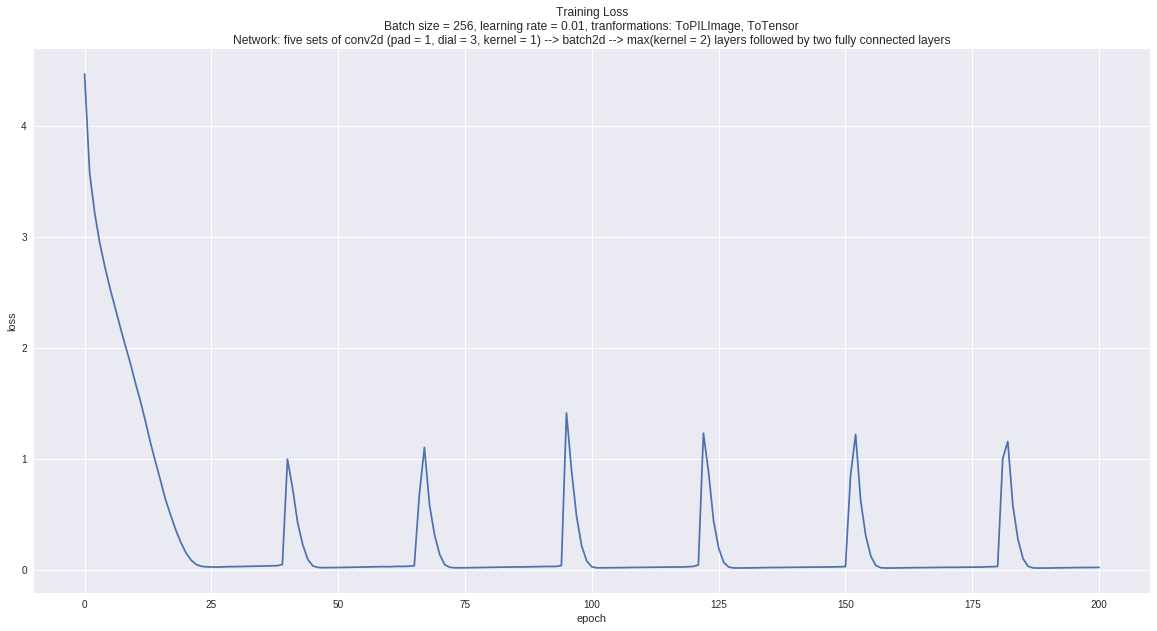

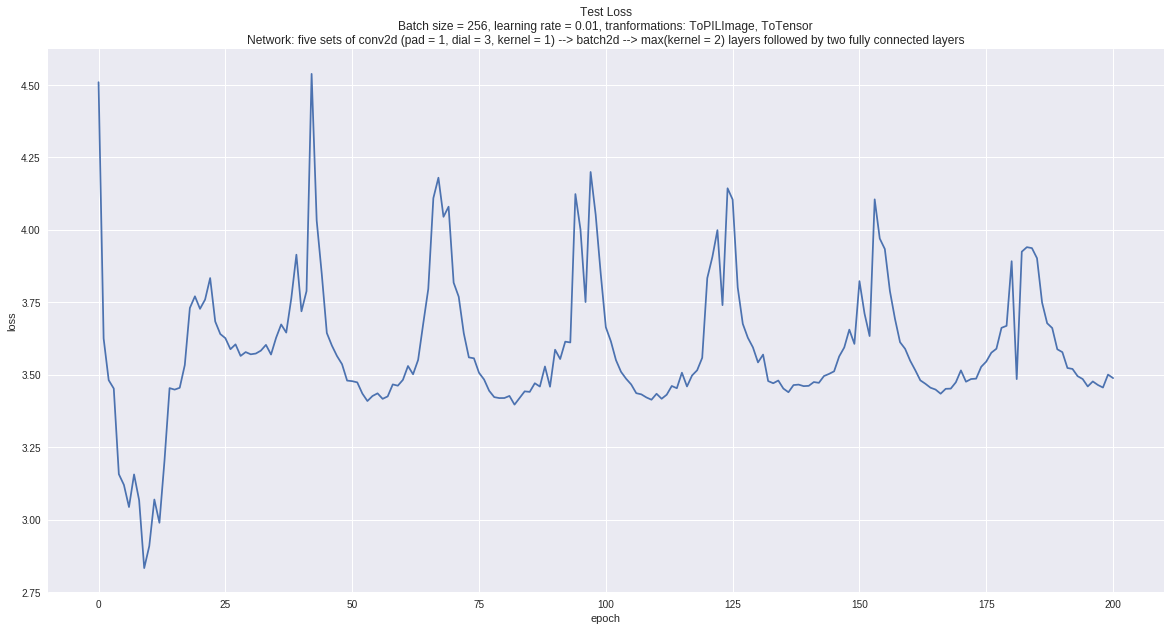

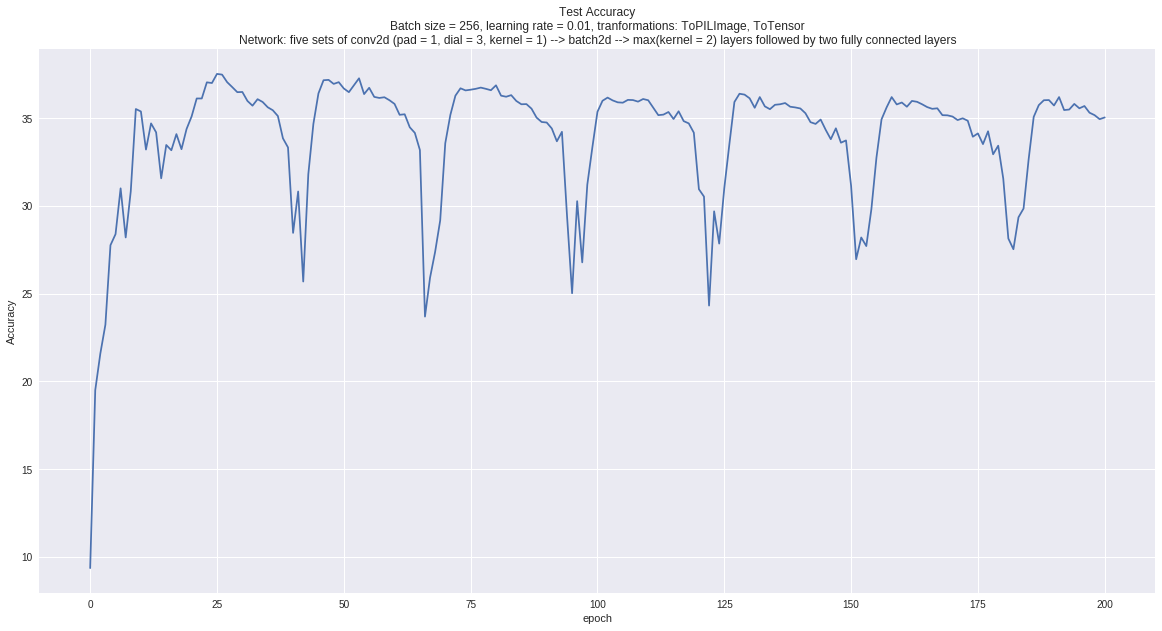

In [0]:
avg_train_losses = [(epoch, trn_lss[0]) for epoch, trn_lss in train_losses]
setting = 'Batch size = {}, learning rate = {}, momentum = {}, decay = {}, tranformations: {}'.format(BATCH_SIZE, LEARNING_RATE, MOMENTUM, WEIGHT_DECAY, TRANSFORMATIONS)

pt_util.plot(*(zip(*avg_train_losses)), 'Training Loss\n' + setting + '\n' + network, 'epoch', 'loss')
pt_util.plot(*(zip(*test_losses)), 'Test Loss\n' + setting + '\n' + network, 'epoch', 'loss')
pt_util.plot(*(zip(*test_accuracies)), 'Test Accuracy\n' + setting + '\n' + network, 'epoch', 'Accuracy')

# Part 6: ImageNet!
ImageNet is the big granddaddy of supervised vision datasets. It's the dataset that got the whole deep learning train running. We thought it would be fun for you guys to try your hand at it.

A few notes:
- Downloading ImageNet should take about 7 minutues. Extracting should take another 7 minutes. So run this code, then go have a coffee or whatever.
- The data will be removed after 24 hours or so. That's just how Colab works. Each time you reset the environment, you will also have to redownload ImageNet. 
    - I would recommend against storing it on your on Google Drive though as that is way slower to read during training.
    - Through extensive testing, we have found that the fastest way to get the data is the code we provide (faster than saving to google drive, uploading by hand, etc.) 
- Reading images directly with PIL seems to have issues on Colab. Instead try cv2.imread.
    - cv2.imread returns images in bgr order. To go from bgr -> rgb, use    `im = im[:, :, ::-1]`
- The images are provided such that the minimum side length is at least 128 unless the original image was too small for it to be shrunk.
    - transforms.Resize will be your friend
- It seams you cannot use a batch size > 64 x 128 x 128 x 3 while still using multiprocessing due to Colab limitations. You can use larger batches if you set num_workers = 0, but it will be much slower.
- This dataset has 1000 classes, whereas Tiny ImageNet only had 200.
- You will probably want to save your results more than once every epoch since Colab may spurriously shut down your session.
- We know this takes a long time to run. Try leaving it overnight. We don't expect you to get state-of-the-art performance.
- `glob.glob` is a good Python function for reading lots of folder/file names, but it does not return a sorted list.




In [0]:
# Downloads and extracts the data
if not os.path.exists('imagenet128'):
    !echo $(date +%x_%r)
    !gsutil cp gs://imagenet-cropped/imagenet128.tar .
    !echo $(date +%x_%r)
    !tar -xf imagenet128.tar
    !echo $(date +%x_%r)
    !ls imagenet128/train | head -4

12/13/2018_11:22:42 PM
Copying gs://imagenet-cropped/imagenet128.tar...
| [1 files][ 23.7 GiB/ 23.7 GiB]   49.7 MiB/s                                   
Operation completed over 1 objects/23.7 GiB.                                     
12/13/2018_11:29:07 PM
12/13/2018_11:34:48 PM
n01440764
n01443537
n01484850
n01491361


In [0]:
# Sets up synset data. Have a look at what is in these dictionaries as they may help you with debugging.
import json
imagenet_synset_data = json.load(open('imagenet128/imagenet_synsets.json'))
synset_id_to_cls = {val['id']: int(key) for key, val in imagenet_synset_data.items()}

In [0]:
import glob
import cv2

# Data loader
class ImageFolderLoader(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        # raise NotImplementedError
        # YSS DONE!
        self.filenames = sorted(glob.glob('{}/*/*.JPEG'.format(folder)))
        # QUESTION: why do we need to sort the file names?
        self.transform = transform

    def __len__(self):
        # raise NotImplementedError
        # YSS DONE!
        return len(self.filenames)

    def __getitem__(self, idx):
        # raise NotImplementedError
        # YSS DONE!
        # read the image
        data = cv2.imread(self.filenames[idx])
        # extract the label from the filename
        label = self.filenames[idx].split('/')[-2]
        # map the label to the class number
        label = [synset_id_to_cls[label]]
        
        # tranform data from bgr to rgb
        data = data[:, :, ::-1]
        # QUESTION why to tranform from bgr to rgb? I think it's just about the
        #          order of input channels which should not matter in the end.
        # apply any other tranformations
        if self.transform:
          data = self.transform(data)
        label = torch.LongTensor(np.array(label))
        return (data, label)


In [0]:
train_transforms = None

# YSS DONE!
train_transforms = transforms.Compose([
                                       transforms.ToPILImage(mode=None),
                                       transforms.Resize([128, 128]),
                                       #transforms.Normalize([0, 0, 0], [1, 1, 1]),
                                       transforms.ToTensor()
                                      ]) 

test_transforms = None

# YSS DONE!
test_transforms = transforms.Compose([
                                      transforms.ToPILImage(mode=None),
                                      transforms.Resize([128, 128]),
                                      #transforms.Normalize([0, 0, 0], [1, 1, 1]),
                                      transforms.ToTensor()
                                     ]) 


TRANSFORMATIONS = 'ToPILImage, Resize(128), ToTensor'


data_train = ImageFolderLoader('imagenet128/train', transform=train_transforms)
assert(len(data_train) == 1281167)
data_test = ImageFolderLoader('imagenet128/val', transform=test_transforms)
assert(len(data_test) == 50000)

In [0]:
KERNEL = 3
PADDING = 1
DIALATION = 1

network = 'Network: seven sets of conv2d (pad = {}, dial = {}, kernel = {}) --> batch2d --> max(kernel = 2) layers followed by a fully connected layers'.format(PADDING, KERNEL, DIALATION)

class FullImagenetNet(TinyImagenetNet):
    def __init__(self):
        super(FullImagenetNet, self).__init__()
        # raise NotImplementedError
        # YSS DONE!
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 128x128x3 -> 128x128x32
        self.batch1 = nn.BatchNorm2d(32) # 128x128x32 -> 128x128x32
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64x64x32 -> 64x64x64
        self.batch2 = nn.BatchNorm2d(64) # 64x64x64 -> 64x64x64
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 32x32x64 -> 32x32x128
        self.batch3 = nn.BatchNorm2d(128) # 32x32x128 -> 32x32x128
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 16x16x128 -> 16x16x256
        self.batch4 = nn.BatchNorm2d(256) # 16x16x256 -> 16x16x256
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # 8x8x256 -> 8x8x512
        self.batch5 = nn.BatchNorm2d(512) # 8x8x512 -> 8x8x512
        
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # 4x4x512 -> 4x4x1024
        self.batch6 = nn.BatchNorm2d(1024) # 4x4x1024 -> 4x4x1024
        
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1) # 2x2x1024 -> 2x2x2048
        self.batch7 = nn.BatchNorm2d(2048) # 2x2x2048 -> 2x2x2048
        
        self.fc1 = nn.Linear(2048, 1000)
        self.best_performance = 0


    def forward(self, x):
        # raise NotImplementedError
        # YSS DONE!
        x = F.relu(F.max_pool2d(self.batch1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.batch2(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.batch3(self.conv3(x)), 2))
        x = F.relu(F.max_pool2d(self.batch4(self.conv4(x)), 2))
        x = F.relu(F.max_pool2d(self.batch5(self.conv5(x)), 2))
        x = F.relu(F.max_pool2d(self.batch6(self.conv6(x)), 2))
        x = F.relu(F.max_pool2d(self.batch7(self.conv7(x)), 2))
        x = x.view(-1, 2048)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


Using device cuda
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([32, 3, 3, 3]) = 0MB
conv1.bias -> 	torch.Size([32]) = 0MB
batch1.weight -> 	torch.Size([32]) = 0MB
batch1.bias -> 	torch.Size([32]) = 0MB
batch1.running_mean -> 	torch.Size([32]) = 0MB
batch1.running_var -> 	torch.Size([32]) = 0MB
batch1.num_batches_tracked -> 	torch.Size([]) = 0MB
conv2.weight -> 	torch.Size([64, 32, 3, 3]) = 0MB
conv2.bias -> 	torch.Size([64]) = 0MB
batch2.weight -> 	torch.Size([64]) = 0MB
batch2.bias -> 	torch.Size([64]) = 0MB
batch2.running_mean -> 	torch.Size([64]) = 0MB
batch2.running_var -> 	torch.Size([64]) = 0MB
batch2.num_batches_tracked -> 	torch.Size([]) = 0MB
conv3.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
conv3.bias -> 	torch.Size([128]) = 0MB
batch3.weight -> 	torch.Size([128]) = 0MB
batch3.bias -> 	torch.Size([128]) = 0MB
batch3.running_mean -> 	torch.Size([128]) = 0MB
batch3.running_var -> 	torch.Size([128]) = 0MB
batch3.num_batches_tracked -> 	torch.Size([]) = 0MB
conv4.weight ->

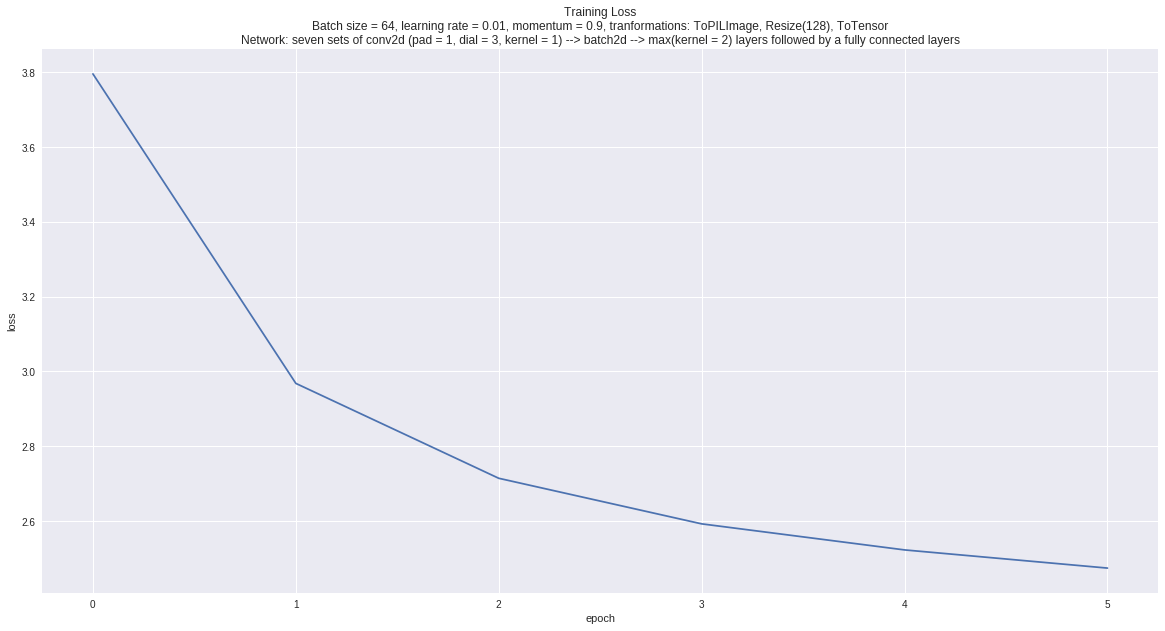

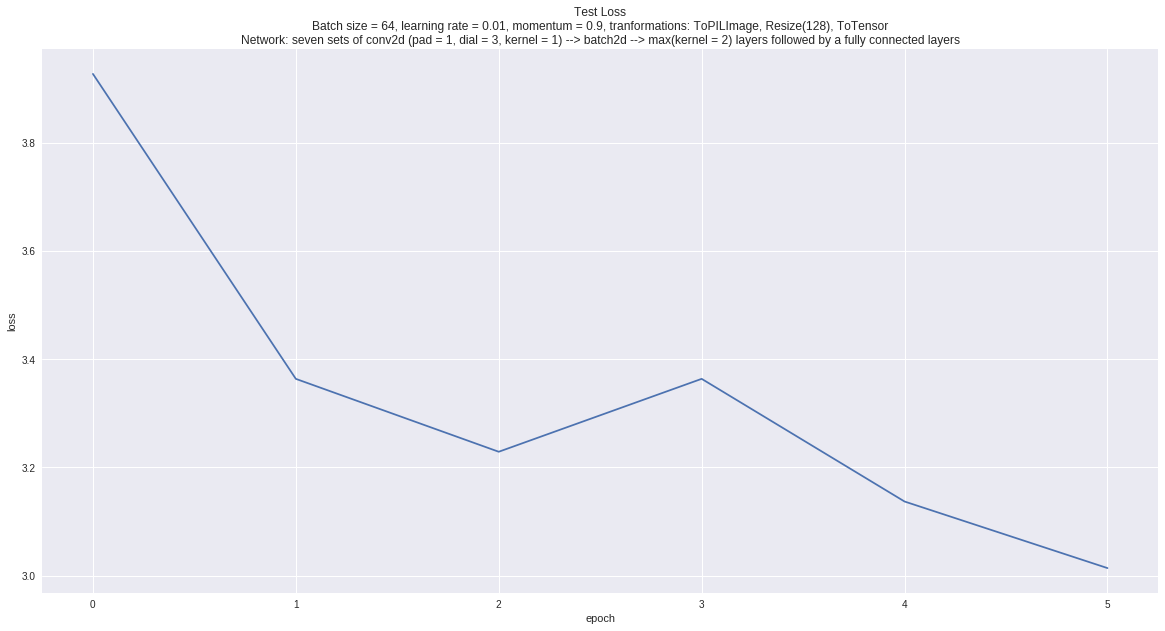

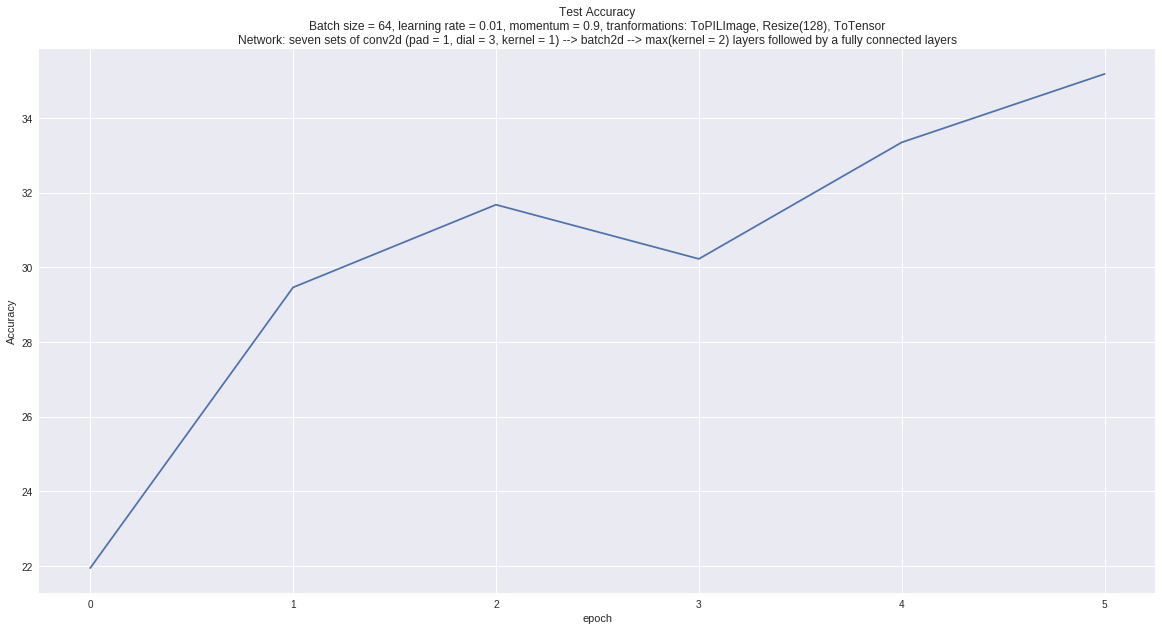

In [16]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 50
EPOCHS = 5
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
CHECKPOINT_PATH = BASE_PATH + 'imagenet_full/checkpoints'
LOG_PATH = BASE_PATH + 'imagenet_full/' + 'log/log.pkl' # YSS DONE!

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}


class_names = sorted([(int(key), val['label'].split(',')[0]) for key, val in imagenet_synset_data.items()])
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = FullImagenetNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(CHECKPOINT_PATH)

# YSS DONE!
# start from where you left off
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL) # YSS DONE!
        test_loss, test_accuracy = test(model, device, test_loader, False) # YSS DONE!
        # keep track of train/test loss and test accuracy to plot it later
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        # log the performance metrics
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        # saving the best model
        model.save_best_model(test_accuracy, CHECKPOINT_PATH + '/%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(CHECKPOINT_PATH + '/%03d.pt' % epoch, 0)
    
    # YSS DONE!
    avg_train_losses = [(epoch, trn_lss[0]) for epoch, trn_lss in train_losses]
    setting = 'Batch size = {}, learning rate = {}, momentum = {}, tranformations: {}'.format(BATCH_SIZE, LEARNING_RATE, MOMENTUM, TRANSFORMATIONS)
    
    pt_util.plot(*(zip(*avg_train_losses)), 'Training Loss\n' + setting + '\n' + network, 'epoch', 'loss')
    pt_util.plot(*(zip(*test_losses)), 'Test Loss\n' + setting + '\n' + network, 'epoch', 'loss')
    pt_util.plot(*(zip(*test_accuracies)), 'Test Accuracy\n' + setting + '\n' + network, 'epoch', 'Accuracy')

In [0]:
PADDING = 1
DIALATION = 1
KERNEL = 3
BATCH_SIZE = 64
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
LOG_PATH = BASE_PATH + 'imagenet_full/' + 'log/log.pkl'

network = 'Network: seven sets of conv2d (pad = {}, dial = {}, kernel = {}) --> batch2d --> max(kernel = 2) layers followed by a fully connected layers'.format(PADDING, KERNEL, DIALATION)
TRANSFORMATIONS = 'ToPILImage, Resize(128), ToTensor'

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

In [0]:
avg_train_losses = [(epoch, trn_lss[0]) for epoch, trn_lss in train_losses]
setting = 'Batch size = {}, learning rate = {}, momentum = {}, decay = {}, tranformations: {}'.format(BATCH_SIZE, LEARNING_RATE, MOMENTUM, WEIGHT_DECAY, TRANSFORMATIONS)

pt_util.plot(*(zip(*avg_train_losses)), 'Training Loss\n' + setting + '\n' + network, 'epoch', 'loss')
pt_util.plot(*(zip(*test_losses)), 'Test Loss\n' + setting + '\n' + network, 'epoch', 'loss')
pt_util.plot(*(zip(*test_accuracies)), 'Test Accuracy\n' + setting + '\n' + network, 'epoch', 'Accuracy')

# Part 7: Short answer questions
Please answer these questions, and put the answers in a file called homework1_python.pdf in your repository.

# Tiny ImageNet
1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.
2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.
3. Why do you think the best one worked well and the worst one worked poorly.


# Full ImageNet
1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from Tiny ImageNet question 1.
2. Were you able to use larger/deeper networks on Full ImageNet than you used on Tiny ImageNet and increase accuracy? If so, why? If not, why not?
3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet (32x32)? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

Additionally, download your .ipynb and put it in your repository and name it homework1_colab.ipynb

